# Notebook 4: Spectral & Wavelet Analysis


## Preamble
Analyzing the frequency content of time series is a critical task in many of the paleosciences. 

In this notebook we demonstrate how to use the spectral analysis features of Pyleoclim using the "ODP846" record described in:

- Mix, A. C., J. Le, and N. J. Shackleton (1995a), Benthic foraminiferal stable isotope stratigraphy from Site 846: 0–1.8 Ma, Proc. Ocean Drill. Program Sci. Results, 138, 839–847.
- Shackleton, N. J. (1995), New data on the evolution of Pliocene climate variability, in Paleoclimate and Evolution, With Emphasis on Human Origins, edited by E. S. Vrba et al., pp. 242-248, Yale Univ. Press, New Haven, CT.

The record was aligned to the Benthic Stack of [Lisiecki & Raymo (2005)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2004PA001071) using the [HMM-Match](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014PA002713) algorithm [(Khider et al, 2017)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2016PA003057).  The latter is a probabilistic method that generates an ensemble of 1000 possible age models compatible with the chronostratigraphic constraints.

After invoking some useful packages, we first load the LiPD file containing the data:

In [1]:
import pyleoclim as pyleo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pyleo.set_style('web')

d = pyleo.Lipd('../data/ODP846.Lawrence.2006.lpd')
v=d.to_tso()
ts=pyleo.LipdSeries(v)  # use series 8 (temp muller)

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: ODP846.Lawrence.2006.lpd
2.73 MB :That's a big file! This may take a while to load...
Finished read: 1 record
extracting paleoData...
extracting: ODP846.Lawrence.2006
Created time series: 18 entries
0 :  ODP846.Lawrence.2006 :  site/hole
1 :  ODP846.Lawrence.2006 :  section
2 :  ODP846.Lawrence.2006 :  interval
3 :  ODP846.Lawrence.2006 :  depth
4 :  ODP846.Lawrence.2006 :  age
5 :  ODP846.Lawrence.2006 :  temp prahl
6 :  ODP846.Lawrence.2006 :  c37 total
7 :  ODP846.Lawrence.2006 :  ukprime37
8 :  ODP846.Lawrence.2006 :  temp muller
9 :  ODP846.Lawrence.2006 :  event
10 :  ODP846.Lawrence.2006 :  depth
11 :  ODP846.Lawrence.2006 :  sample label
12 :  ODP846.Lawrence.2006 :  depth comp
13 :  ODP846.Lawrence.2006 :  depth cr
14 :  ODP846.Lawrence.2006 :  c. wuellerstorfi d18o
15 :  ODP846.Lawrence.2006 :  c. wuellerstorfi d13c
16 :  ODP846.Lawrence.2006 :  u. peregrina d18o
17 :  ODP846.Lawrence.2006 :  

Enter the number of the variable you wish to use:  8


The file is now loaded in memory, but it contains many parts. The next step is to extract the relevant parts. To have a first look, we load and plot them in turn:

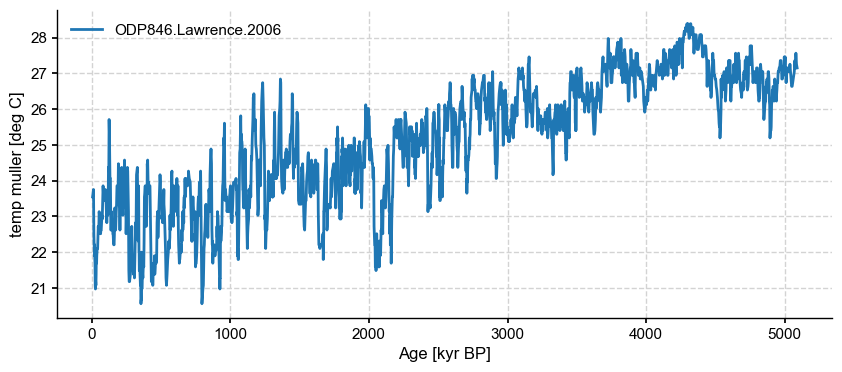

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Age [kyr BP]', ylabel='temp muller [deg C]'>)

In [2]:
ts.plot()

This paleoclimate record features:

- a long-term cooling trend ($\delta^{18}\mathrm{O}$ gets more positive over time) characteristic of late Neogene and Quaternary.
- some quasi-periodic oscillations (the legendary [Pleistocene Ice Ages](https://www.ncdc.noaa.gov/abrupt-climate-change/Glacial-Interglacial%20Cycles))
- nonstationary behavior, related to the well-known mid-Pleistocene transition from a "41k world" to a "100k world" somewhere around 0.8 Ma [(Paillard, 2001)](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2000RG000091).

A standard assumption of spectral analysis is that data are evenly spaced in time. In real-world paleo timeseries this is seldom the case. Let's look at the distribution of time increments in this particular core, as contrained by this tuned age model:

In [3]:
age = pyleo.LipdSeries(v)  # pick number 4

0 :  ODP846.Lawrence.2006 :  site/hole
1 :  ODP846.Lawrence.2006 :  section
2 :  ODP846.Lawrence.2006 :  interval
3 :  ODP846.Lawrence.2006 :  depth
4 :  ODP846.Lawrence.2006 :  age
5 :  ODP846.Lawrence.2006 :  temp prahl
6 :  ODP846.Lawrence.2006 :  c37 total
7 :  ODP846.Lawrence.2006 :  ukprime37
8 :  ODP846.Lawrence.2006 :  temp muller
9 :  ODP846.Lawrence.2006 :  event
10 :  ODP846.Lawrence.2006 :  depth
11 :  ODP846.Lawrence.2006 :  sample label
12 :  ODP846.Lawrence.2006 :  depth comp
13 :  ODP846.Lawrence.2006 :  depth cr
14 :  ODP846.Lawrence.2006 :  c. wuellerstorfi d18o
15 :  ODP846.Lawrence.2006 :  c. wuellerstorfi d13c
16 :  ODP846.Lawrence.2006 :  u. peregrina d18o
17 :  ODP846.Lawrence.2006 :  u. peregrina d13c


Enter the number of the variable you wish to use:  4


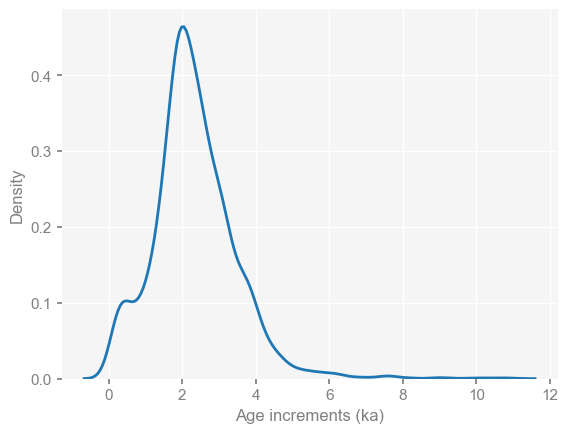

In [15]:
dt = np.diff(age.value)
fig, ax = plt.subplots()
sns.kdeplot(dt,ax=ax)
ax.set_xlabel('Age increments (ka)')
pyleo.showfig(fig)

Notice that we had to manually set the units here. This application is a bit more customized, so this step hasn't been automated in `pyleoclim` yet. 

We see that over the past 1 Ma, the time increments are sharply peaked around 2 ka, but they range from 0 to about 7.5 ka. For now, let us assume that the time axis, albeit uneven, is well-known (no uncertainty). 

## Time-certain spectral analysis 
From this point there are two ways to proceed: 1) use methods that explictly deal with unevenly-spaced data, or 2) interpolate to a regular grid and apply standard methods. 

### Gap-friendly methods

`pyleoclim` offers access to two methods that are tolerant of time gaps (non-uniform spacing): 
- the Lomb-Scargle periodogram, emulating many aspects of the famous [REDFIT](https://boris.unibe.ch/id/eprint/38577) code.
- the Weighted Wavelet Z-transform (Foster, 1996), referred to as WWZ. 

The latter has many interesting properties, particularly in regarding to estimating scaling laws (Kirchner & Neal, PNAS, 2013). However, its current implementation is relatively onerous. This typically isn't an issue for a single estimation, but it makes it impractical for Monte-Carlo assessments of significance (where the spectral estimation is carried out hundreds to thousands of times). 

Let us first see what that looks like:

In [16]:
psd_wwz = ts.spectral(method='wwz')  # method='wwz' by default

The object returned by this method is of the class [PSD](https://pyleoclim-util.readthedocs.io/en/stable/core/ui.html?highlight=PSD#psd-pyleoclim-psd) (for Power Spectral Density), and comes with various amenities, which will appear if you type the object (here `psd_wwz`) followed by a dot, then type the "tab" key. The first is a method for plotting, with a single flick of the keyboard:

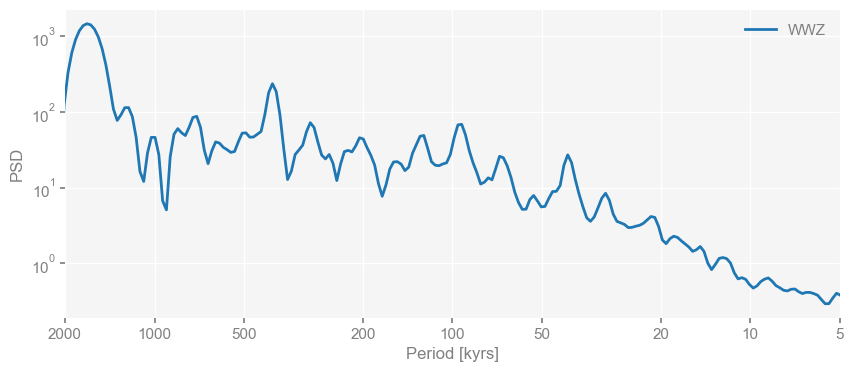

In [17]:
fig, ax = psd_wwz.plot(label='WWZ')

Several things are done here: the plot is expressed in log-log units, so that scaling laws appear as straight lines (see "Model-data confrontation #1). However, frequency axes can be notoriously hard to read, so the abscissa is expressed in terms of the period of oscillation, which is a lot easier to understand. Finally, notice that the code made use of the units in the LiPD file, and expressed the period in "kyrs". If you prefer "ka", say, this is easily customized with another flick of the wand, but we thought you'd apprediate not to have to micromanage the details to get a decent plot going.    

Like most spectral methods, WWZ uses a control parameter called the decay constant, $c$. 



Before we go any further in the analysis, let us see what we would get

In [23]:
psd_wwz = ts.spectral(method='wwz',settings={'c',1/(8*np.pi**2)}) 

TypeError: cannot convert dictionary update sequence element #0 to a sequence

In [21]:
beta_wwz = psd_wwz.beta_est()

In [18]:
psd_ls = ts.spectral(method='lomb_scargle') 
psd_ls.plot(label='WWZ',ax=ax)

DETRENDING: Before we do anything else, however, it would be prudent to remove the secular trend, which will otherwise dominate the low-frequency ... [TODO] 

### Gap-intolerant methods
2. In the second case, we can put the timeseries on a uniformly-spaced timescale (by binning or interpolation; both will be illustrated below), then use a method tailored to evenly-spaced data. 



`pyleoclim` offers a plethora of them: the classic periodogram https://pyleoclim-util.readthedocs.io/en/stable/utils/spectral/periodogram.html#utils-periodogram MTM, Welch, . 

